In [23]:
import tensorflow as tf
import os
import seaborn as sns
import cv2

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import load_model


In [24]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# setup

In [42]:
data_dir = os.path.join('data', 'train')

batch_size = 64

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=(128, 128), label_mode='categorical', batch_size=batch_size, seed=666)
classes = data.class_names
print(classes)
data = data.map(lambda x, y: (x/255.0, y))

batch = next(iter(data))



Found 16130 files belonging to 3 classes.
['cat', 'dog', 'wild']


0.0


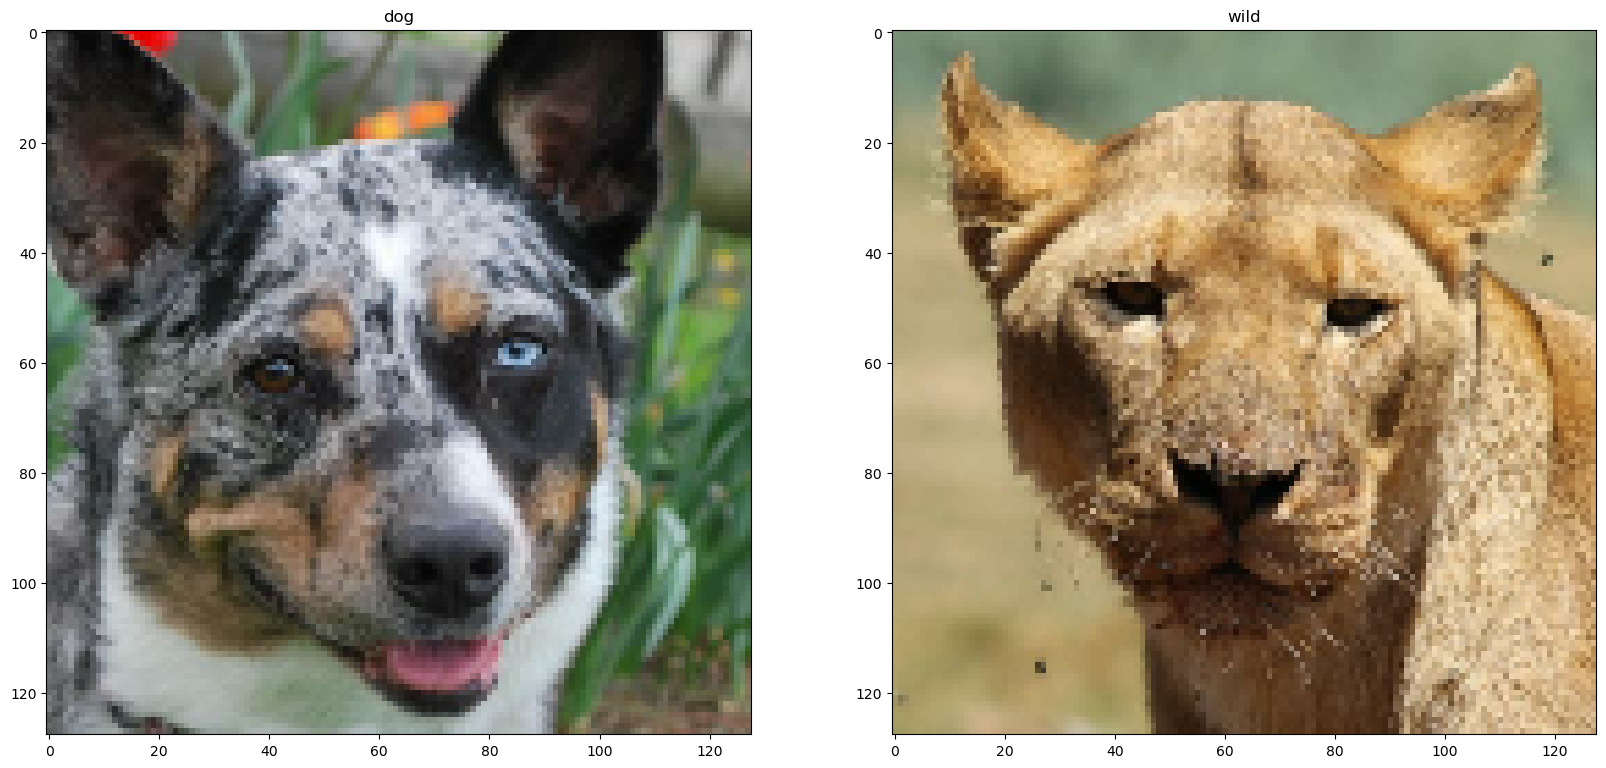

In [49]:
data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

print(batch[0].min())

fig, ax = plt.subplots(ncols=2, figsize=(20,20))
for idx, img in enumerate(batch[0][:2]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(classes[np.argmax(batch[1][idx])])

In [50]:
print(f'total images: 32 (batch size) x {len(data)} (batches) => {batch_size*len(data)} images')

train_size = int(len(data)*.7)
print(f'\ntrain size: {train_size * batch_size} images')
train = data.take(train_size)

val_size = int(len(data)*.2)
print(f'\nvalidation size: {val_size * batch_size} images')
val = data.skip(train_size).take(val_size)

test_size = int(len(data)*.1)
print(f'\ntest size: {test_size * batch_size} images')
test = data.skip(train_size+val_size).take(test_size)

total images: 32 (batch size) x 253 (batches) => 16192 images

train size: 11328 images

validation size: 3200 images

test size: 1600 images


In [51]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 128)     

In [53]:
hist = model.fit(train, epochs=8, validation_data=val, batch_size=batch_size)

Epoch 1/8


177/177 [==============================] - 14s 70ms/step - loss: 0.6810 - accuracy: 0.6792 - val_loss: 0.1792 - val_accuracy: 0.9300
Epoch 2/8
177/177 [==============================] - 11s 61ms/step - loss: 0.1960 - accuracy: 0.9308 - val_loss: 0.1397 - val_accuracy: 0.9513
Epoch 3/8
177/177 [==============================] - 11s 58ms/step - loss: 0.1172 - accuracy: 0.9605 - val_loss: 0.0982 - val_accuracy: 0.9691
Epoch 4/8
177/177 [==============================] - 10s 57ms/step - loss: 0.0676 - accuracy: 0.9783 - val_loss: 0.0693 - val_accuracy: 0.9778
Epoch 5/8
177/177 [==============================] - 10s 57ms/step - loss: 0.0510 - accuracy: 0.9823 - val_loss: 0.0769 - val_accuracy: 0.9769
Epoch 6/8
177/177 [==============================] - 10s 57ms/step - loss: 0.0421 - accuracy: 0.9853 - val_loss: 0.0875 - val_accuracy: 0.9722
Epoch 7/8
177/177 [==============================] - 12s 67ms/step - loss: 0.0306 - accuracy: 0.9901 - val_loss: 0.0708 - val_accuracy: 0.9791
Epoch 8/8

<Axes: >

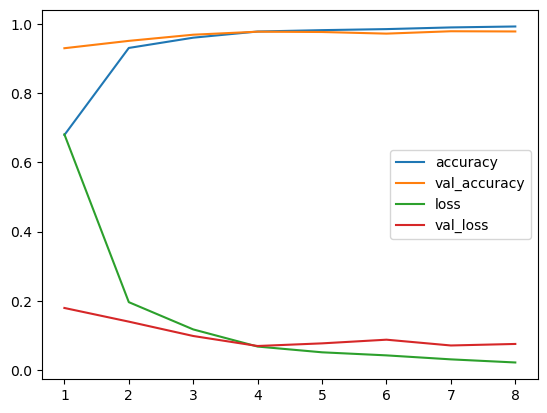

In [54]:
sns.lineplot(x=range(1, len(hist.history['accuracy'])+1), y=hist.history['accuracy'], label='accuracy')
sns.lineplot(x=range(1, len(hist.history['val_accuracy'])+1), y=hist.history['val_accuracy'], label='val_accuracy')
sns.lineplot(x=range(1, len(hist.history['loss'])+1), y=hist.history['loss'], label='loss')
sns.lineplot(x=range(1, len(hist.history['val_loss'])+1), y=hist.history['val_loss'], label='val_loss')


In [33]:
eval = model.evaluate(test)

28/28 [==============================] - 6s 14ms/step - loss: 0.0725 - accuracy: 0.9815


1/1 [==============================] - 0s 18ms/step
[1]


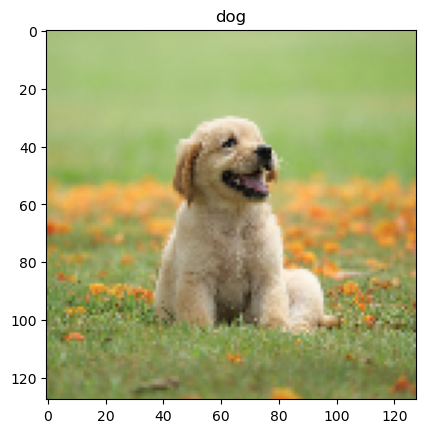

In [40]:
test_image = cv2.imread('test_dog.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

resized_image = tf.image.resize(test_image, (128, 128))


y_pred = model.predict(tf.expand_dims(resized_image/255, 0))

# Take the argmax to get the predicted class index
predicted_class_indices = np.argmax(y_pred, axis=1)

print(predicted_class_indices)

plt.imshow(resized_image.numpy().astype('int'))
plt.title(classes[predicted_class_indices[0]])
plt.show()

In [62]:
pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    x, y = batch
    print(batch)
    y_pred = model.predict(x)

    acc.update_state(y, y_pred)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)

print(f'accuracy: {acc.result()}')
print(f'precision: {pre.result()}')
print(f'recall: {rec.result()}')

(array([[[[0.58235294, 0.70392156, 0.40588236],
         [0.58235294, 0.70392156, 0.40588236],
         [0.5892157 , 0.7107843 , 0.4127451 ],
         ...,
         [0.2872549 , 0.4127451 , 0.01078431],
         [0.26666668, 0.39803922, 0.01176471],
         [0.31666666, 0.45784312, 0.05392157]],

        [[0.5901961 , 0.7117647 , 0.4137255 ],
         [0.5901961 , 0.7117647 , 0.4137255 ],
         [0.58235294, 0.70392156, 0.40588236],
         ...,
         [0.28921568, 0.4372549 , 0.02647059],
         [0.28333333, 0.43823528, 0.03627451],
         [0.25784314, 0.41862744, 0.03235294]],

        [[0.5882353 , 0.70980394, 0.4117647 ],
         [0.5882353 , 0.70980394, 0.4117647 ],
         [0.57843137, 0.7       , 0.4019608 ],
         ...,
         [0.23529412, 0.38235295, 0.00588235],
         [0.24705882, 0.40098038, 0.00882353],
         [0.22156863, 0.37745097, 0.02254902]],

        ...,

        [[0.5372549 , 0.6862745 , 0.36078432],
         [0.5372549 , 0.6862745 , 0.36078432

In [78]:
from sklearn.metrics import classification_report
y_true = np.concatenate([y.numpy() for x, y in test], axis=0)
y_true = np.argmax(y_true, axis=1)

print(y_true)

y_pred = model.predict(test).argmax(axis=1)
print(classification_report(y_pred, y_true))

[2 0 2 ... 1 1 1]
25/25 [==============================] - 5s 22ms/step
              precision    recall  f1-score   support

           0       0.37      0.36      0.36       572
           1       0.35      0.36      0.35       518
           2       0.34      0.34      0.34       510

    accuracy                           0.35      1600
   macro avg       0.35      0.35      0.35      1600
weighted avg       0.35      0.35      0.35      1600



### Save the model

In [60]:
loc = os.path.join(os.getcwd(), 'models', 'model.h5')
localhost_save_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")
model.save(loc, options=localhost_save_option)
